# Пример построенной нейронной сети при помощи Keras

Задача: восстановление пропусков в спутниковых снимках для территории 1 градус широты на 1 градус долготы (г. Мадрид). Массивы данных для обучения и валидации уже стандартизированны. Минимальными значениями в каждой матрице хакодированы пропуски.

In [62]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import pickle

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

Определим параметры для воспроизводимости результатов в будущем.

In [63]:
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Используем видеокарту для обучения нейронной сети

In [64]:
from tensorflow.python.client import device_lib
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16492227081956757623
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2224789913
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7702016419698822552
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [147]:
# Загружаем данные 
X = np.load('D:/Madrid_LST_neural_network/Train/X.npy')
Y = np.load('D:/Madrid_LST_neural_network/Train/Y.npy')

# Разделяем на "обучение" и "тест"
X_train = X[:2000,:,:]
X_test = X[2000:, :, :]
Y_train = Y[:2000,:,:]
Y_test = Y[2000:, :, :]

print(f'Размерность массива в обучающей выборке {Y_train.shape}')
print(f'Размерность массива в тестовой выборке {Y_test.shape}')

# На вход автоэнкодеру подаются данные следующей размерности
input_img = Input(shape=(110, 88, 1))

# Будем использовать небольшое количесство фильтров 
x = Conv2D(64, (8, 8), activation='relu', padding = 'same', kernel_initializer='he_normal')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (4, 4), activation='relu', padding='same', kernel_initializer='random_normal')(x)
x = MaxPooling2D((1, 1), padding='same')(x)
encoded = Conv2D(1, (4, 4), activation='relu', padding='same')(x)

# Мы дважды провернули операцию пулинга на картах окном 2 на 2
# На этом моменте представление (55, 44, 1)

input_encoded = Input(shape=(55, 44, 1))
x = Conv2D(32, (4, 4), activation='relu', padding='same', kernel_initializer='random_normal')(input_encoded)
x = UpSampling2D((2, 2), interpolation='bilinear')(x)
x = Conv2D(64, (8, 8), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = UpSampling2D((1, 1), interpolation='bilinear')(x)
decoded = Conv2D(1, (1, 1), activation='linear', padding='same')(x) 

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(loss = 'mae', optimizer = 'adadelta', metrics = ['mse'])
autoencoder.summary()

Размерность массива в обучающей выборке (2000, 110, 88, 1)
Размерность массива в тестовой выборке (658, 110, 88, 1)
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 110, 88, 1)]      0         
_________________________________________________________________
encoder (Model)              (None, 55, 44, 1)         37473     
_________________________________________________________________
decoder (Model)              (None, 110, 88, 1)        131745    
Total params: 169,218
Trainable params: 169,218
Non-trainable params: 0
_________________________________________________________________


Нейросеть обучаем несколько раз по 25 эпох. В данном случае - 2 раза по 25 эпох.

In [156]:
# Обучение на 20 эпох 
hist = autoencoder.fit(X_train, Y_train, shuffle=False, validation_data = (X_test, Y_test), epochs = 25, batch_size = 32)

Train on 2000 samples, validate on 658 samples
Epoch 1/25
2000/2000 [==============================] - 12s 6ms/sample - loss: 0.1639 - mse: 0.0496 - val_loss: 0.1715 - val_mse: 0.0551
Epoch 2/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1618 - mse: 0.0484 - val_loss: 0.1691 - val_mse: 0.0537
Epoch 3/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1598 - mse: 0.0473 - val_loss: 0.1668 - val_mse: 0.0523
Epoch 4/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1579 - mse: 0.0463 - val_loss: 0.1646 - val_mse: 0.0511
Epoch 5/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1562 - mse: 0.0454 - val_loss: 0.1626 - val_mse: 0.0499
Epoch 6/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1545 - mse: 0.0445 - val_loss: 0.1606 - val_mse: 0.0488
Epoch 7/25
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.1528 - mse: 0.0436 - val_loss: 0.1587 - val_mse: 0

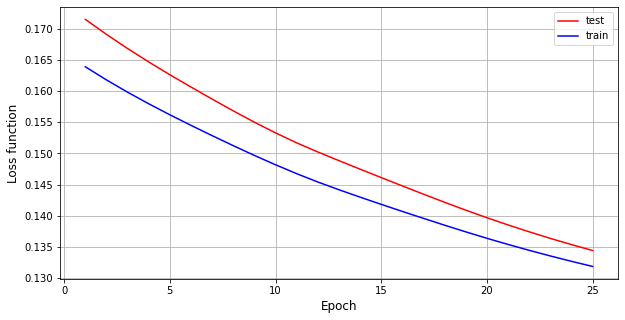

In [157]:
rcParams['figure.figsize'] = 7, 5
results = hist.history

# Ход обучения сети
res_val_loss = results.get('val_loss')
res_val_mse = results.get('val_mse')
res_val_mae = results.get('val_mae')
res_loss = results.get('loss')
res_mse = results.get('mse')
res_mae = results.get('mae')

# Номер эпохи
epochs = range(1,len(res_val_loss)+1)

# Рисуем график
rcParams['figure.figsize'] = 10, 5
plt.plot(epochs, res_val_loss, c = 'red', label = 'test')
plt.plot(epochs, res_loss, c = 'blue', label = 'train')
plt.legend(loc = 'best')
plt.ylabel('Loss function', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.grid()
plt.show()

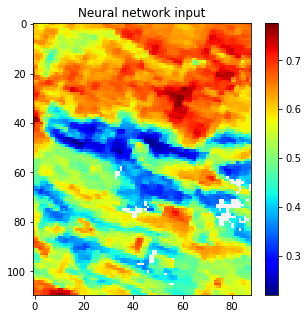

In [161]:
rcParams['figure.figsize'] = 5, 5
num = 1
### Матрица, которая подается на вход алгоритму
matrix = X_test[num]
input_matrix = matrix[:,:,0]

masked_array = np.ma.masked_where(input_matrix == np.min(matrix), input_matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(masked_array, interpolation = 'nearest', cmap = cmap)
plt.colorbar()
plt.title('Neural network input')
plt.show()

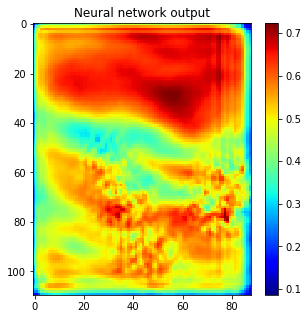

In [162]:
# Для тестовой выборки делаем предсказания
predicted = autoencoder.predict(X_test[:50]) # Для первых 50 объектов чтобы работало побыстрее
matrix_predicted = np.array(predicted[num])
matrix_predicted = matrix_predicted[:,:,0]

# Матрица, которая была предсказана алгоритмом
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(matrix_predicted, interpolation = 'nearest', cmap = cmap)
plt.colorbar()
plt.title('Neural network output')
plt.show()

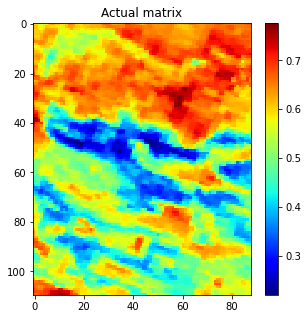

In [163]:
### Матрица, которая должна была быть в действительности
matrix = Y_test[num]
actual_matrix = matrix[:,:,0]

# Копия матрицы
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(actual_matrix, interpolation = 'nearest', cmap = cmap)
plt.colorbar()
plt.title('Actual matrix')
plt.show()

## Сохранение обученной модели

In [ ]:
from keras.models import model_from_json

# serialize model to JSON
model_json = autoencoder.to_json()
with open("D:/Madrid_LST_neural_network/Train/CNN_encoder_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
autoencoder.save_weights("D:/Madrid_LST_neural_network/Train/CNN_encoder_model.h5")
print("Saved model to disk")

## Загрузка обученной модели

In [ ]:
json_file = open('D:/Madrid_LST_neural_network/Train/CNN_encoder_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("D:/Madrid_LST_neural_network/Train/CNN_encoder_model.h5")
print("Loaded model from disk")